In [39]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

Eithan Nakache

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [ ]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd
from IPython.display import Audio
from scipy.io import wavfile
from scipy.signal import spectrogram ,welch

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [41]:
rate, x = wavfile.read("coloniedefourmies.wav")

print("Fréquence d'échantillonnage :", rate)
print("Taille du signal :", x.shape)


Audio(x, rate=rate)

Fréquence d'échantillonnage : 44100
Taille du signal : (376571,)


<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
    </div>

Sample rate: 44100 Hz | duration: 8.54 s | samples: 376571


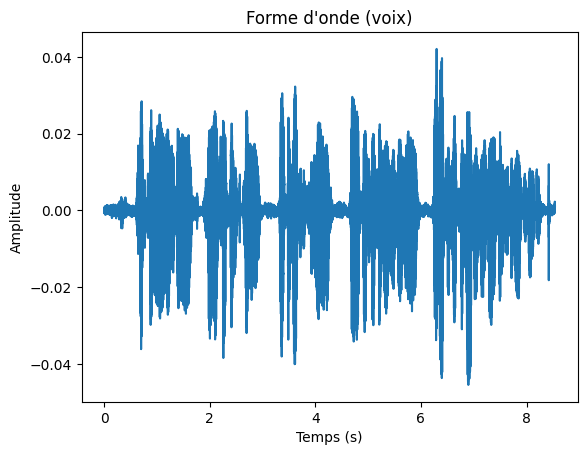

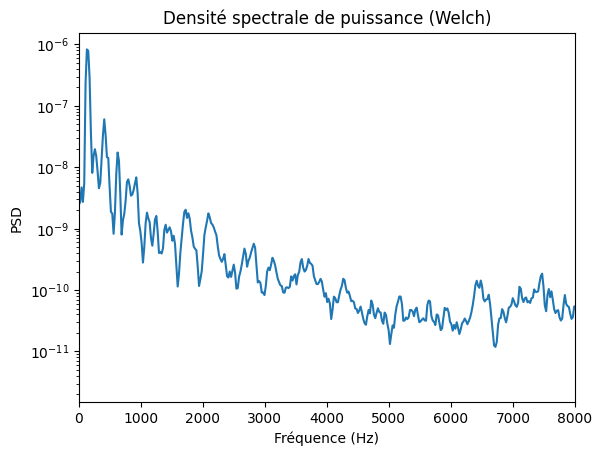

Estimation grossière du fondamental (F0) ≈ 129.2 Hz


In [42]:
t = np.arange(len(x)) / rate
dur = len(x) / rate
print(f"Sample rate: {rate} Hz | duration: {dur:.2f} s | samples: {len(x)}")

plt.figure()
plt.plot(t, x)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("Forme d'onde (voix)")
plt.show()


nperseg = min(len(x), 2048)
f, Pxx = welch(x, fs=rate, window="hann", nperseg=nperseg, noverlap=nperseg//2, detrend="constant")
Pxx_db = 10*np.log10(Pxx + 1e-20)

plt.figure()
plt.semilogy(f, Pxx)  
plt.xlabel("Fréquence (Hz)")
plt.ylabel("PSD")
plt.title("Densité spectrale de puissance (Welch)")
plt.xlim(0, min(rate/2, 8000))
plt.show()


low, high = 50, 300
mask = (f >= low) & (f <= high)
if np.any(mask):
    f0_est = f[mask][np.argmax(Pxx[mask])]
    print(f"Estimation grossière du fondamental (F0) ≈ {f0_est:.1f} Hz")
else:
    print("Pas assez de résolution pour estimer F0.")


<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

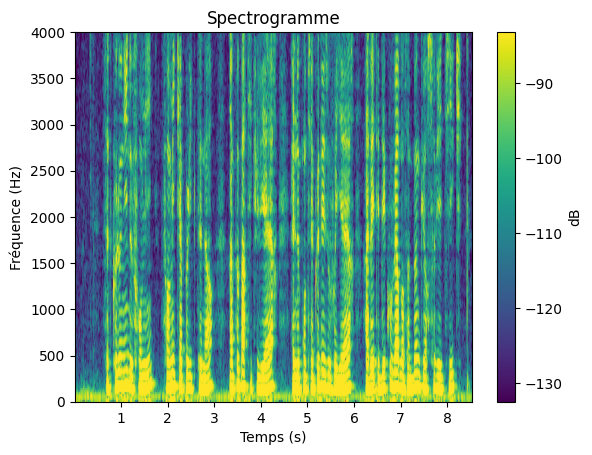

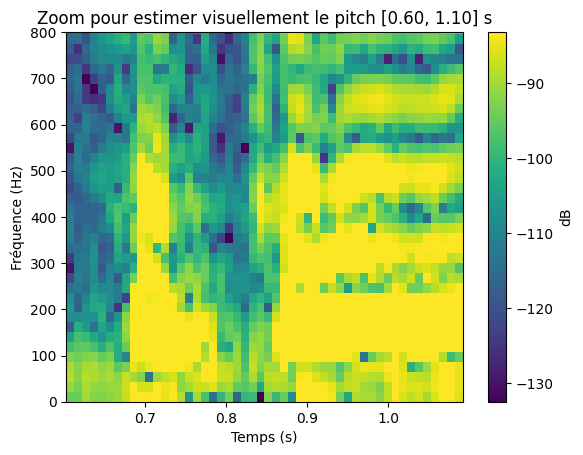

In [43]:
win_ms, hop_ms = 25, 10
nperseg = int(rate * win_ms / 1000)
noverlap = nperseg - int(rate * hop_ms / 1000)
nfft = 1
while nfft < nperseg: nfft *= 2

f, t, S = spectrogram(x, fs=rate, window="hann", nperseg=nperseg, noverlap=noverlap, nfft=nfft, mode="magnitude")
S_db = 20*np.log10(S + 1e-10)
vmin, vmax = np.percentile(S_db, [5, 99])

plt.figure()
plt.imshow(S_db, origin="lower", aspect="auto", extent=[t[0], t[-1], f[0], f[-1]], vmin=vmin, vmax=vmax)
plt.colorbar(label="dB")
plt.xlabel("Temps (s)"); plt.ylabel("Fréquence (Hz)")
plt.title("Spectrogramme"); plt.ylim(0, 4000)
plt.show()

t0, t1 = 0.6, 1.1
mask_t = (t >= t0) & (t <= t1)
plt.figure()
plt.imshow(S_db[:, mask_t], origin="lower", aspect="auto",
           extent=[t[mask_t][0], t[mask_t][-1], f[0], f[-1]], vmin=vmin, vmax=vmax)
plt.colorbar(label="dB")
plt.xlabel("Temps (s)"); plt.ylabel("Fréquence (Hz)")
plt.title(f"Zoom pour estimer visuellement le pitch [{t0:.2f}, {t1:.2f}] s")
plt.ylim(0, 800)
plt.show()


### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

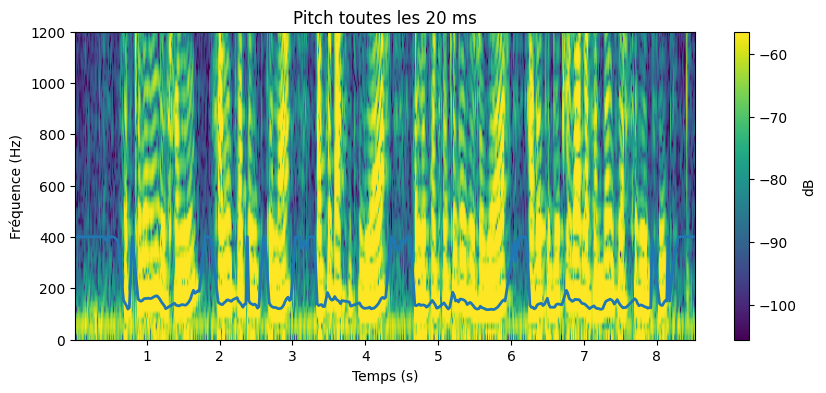

In [44]:
x = x.mean(axis=1) if x.ndim==2 else x
x = x.astype(np.float32); x /= np.max(np.abs(x)) + 1e-12
fs = rate; win = int(fs*0.04); hop = int(fs*0.02)
w = np.hanning(win).astype(np.float32)
fmin, fmax = 60, 400
f0, tc = [], []

for s in range(0, len(x)-win+1, hop):
    fr = x[s:s+win]; fr = fr - fr.mean(); fr *= w
    n = 1
    while n < 2*len(fr): n <<= 1
    X = np.fft.rfft(fr, n); r = np.fft.irfft(X*np.conj(X), n)[:win]
    r = r/(r[0]+1e-12)
    Lmin, Lmax = int(fs/fmax), min(win-1, int(fs/fmin))
    k = Lmin + np.argmax(r[Lmin:Lmax+1]); v = r[k]
    f0.append(fs/k if v > 0.35 else np.nan); tc.append((s+win/2)/fs)

f0, tc = np.array(f0), np.array(tc)

nps, hop_s = int(fs*0.025), int(fs*0.015)
nfft = 1
while nfft < nps: nfft <<= 1
f, t, S = spectrogram(x, fs=fs, window="hann", nperseg=nps, noverlap=nps-hop_s, nfft=nfft, mode="magnitude")
S = 20*np.log10(S+1e-10); vmin, vmax = np.percentile(S, [5, 99])

plt.figure(figsize=(10,4))
plt.imshow(S, origin="lower", aspect="auto", extent=[t[0], t[-1], f[0], f[-1]], vmin=vmin, vmax=vmax)
plt.ylim(0, 1200); plt.colorbar(label="dB")
plt.plot(tc[~np.isnan(f0)], f0[~np.isnan(f0)], linewidth=2)
plt.xlabel("Temps (s)"); plt.ylabel("Fréquence (Hz)"); plt.title("Pitch toutes les 20 ms")
plt.show()


## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [45]:
donnees = np.load('signaux_impulsions.npz')
signaux = donnees['data']
labels = donnees['labels']

## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

In [46]:
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
    e = np.mean(signal**2)
    return e > seuil

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

In [47]:
energies = np.mean(signaux**2, axis=1)

seuil = np.median(energies) + 0.5 * np.std(energies)

pred = np.array([contient_impulsion_energie(s, seuil) for s in signaux])

accuracy = np.mean(pred == labels)

print(f"Seuil = {seuil:.5f} | Précision globale = {accuracy:.3f}")


Seuil = 0.28680 | Précision globale = 0.580


<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [48]:
VP = np.sum((pred == 1) & (labels == 1))
FP = np.sum((pred == 1) & (labels == 0))
VN = np.sum((pred == 0) & (labels == 0))
FN = np.sum((pred == 0) & (labels == 1))

print(f"VP = {VP}, FP = {FP}, VN = {VN}, FN = {FN}")

VP = 2193, FP = 1392, VN = 3604, FN = 2811


## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


In [49]:
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float, fs: int = 1000) -> bool:
    f, _, S = spectrogram(signal, fs=fs, window="hann", nperseg=128, noverlap=96, nfft=256, mode="magnitude")
    return S[(f>=100)&(f<=200)].max(initial=0) > seuil


feat = []
for s in signaux:
    f, _, S = spectrogram(s, fs=1000, window="hann", nperseg=128, noverlap=96, nfft=256, mode="magnitude")
    feat.append(S[(f>=100)&(f<=200)].max(initial=0))
feat = np.array(feat)

seuil = np.median(feat) + 0.5*np.std(feat)

pred = np.array([contient_impulsion_spectrogramme(s, seuil, fs=1000) for s in signaux])

VP = np.sum((pred == 1) & (labels == 1))
FP = np.sum((pred == 1) & (labels == 0))
VN = np.sum((pred == 0) & (labels == 0))
FN = np.sum((pred == 0) & (labels == 1))
acc = np.mean(pred == labels)

print(f"Seuil={seuil:.5f}  |  VP={VP} FP={FP} VN={VN} FN={FN}  |  Acc={acc:.3f}")

Seuil=0.08472  |  VP=4645 FP=0 VN=4996 FN=359  |  Acc=0.964


<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

## <div class=consignes> Comparaison des méthodes </sdivs>


| Méthode       | Seuil   | VP   | FP   | VN   | FN   | Précision |
| ------------- | ------- | ---- | ---- | ---- | ---- | --------- |
| Énergie       | —       | 2193 | 1392 | 3604 | 2811 | ≈ 0.58    |
| Spectrogramme | 0.08472 | 4645 | 0    | 4996 | 359  | 0.96      |

Interprétation

La méthode énergétique fonctionne mal : le bruit a parfois une énergie proche de celle des impulsions, ce qui provoque beaucoup d’erreurs.

La méthode spectrogramme est bien meilleure : l’impulsion crée un pic net entre 100 et 200 Hz, facile à détecter avec un seuil adapté.

Conclusion : l’analyse fréquentielle est plus fiable que la simple mesure d’énergie.

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme: 
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp\text{Signaux détectés comme positifs }}$$
et le rappel comme:
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp \text{Signaux contenant une impulsions}} $$
    
</div>


<div class=consignes> Donnez une interprétation de ces deux métriques </div>

La précision mesure la fiabilité des détections positives : elle indique la proportion de signaux détectés comme contenant une impulsion qui en contiennent réellement. Une précision élevée signifie donc qu’il y a peu de fausses alertes. Le rappel, lui, mesure la capacité du système à repérer toutes les impulsions présentes : il représente la proportion de signaux contenant effectivement une impulsion qui ont été correctement détectés. Un rappel élevé indique peu d’oublis. En résumé, la précision évalue la qualité des détections, tandis que le rappel évalue leur exhaustivité.

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>

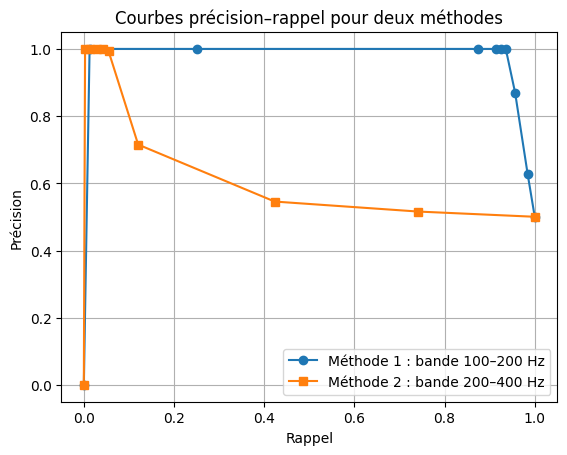

In [50]:
# énergie dans la bande 100–200 Hz
feat1 = []
for s in signaux:
    f, _, S = spectrogram(s, fs=1000, window="hann", nperseg=128, noverlap=96, nfft=256, mode="magnitude")
    feat1.append(S[(f >= 100) & (f <= 200)].max(initial=0))
feat1 = np.array(feat1)

# énergie dans une autre bande (200–400 Hz)
feat2 = []
for s in signaux:
    f, _, S = spectrogram(s, fs=1000, window="hann", nperseg=128, noverlap=96, nfft=256, mode="magnitude")
    feat2.append(S[(f >= 200) & (f <= 400)].max(initial=0))
feat2 = np.array(feat2)

def precision_rappel(feat, labels, seuils):
    precisions, rappels = [], []
    for thr in seuils:
        pred = feat > thr
        VP = np.sum((pred == 1) & (labels == 1))
        FP = np.sum((pred == 1) & (labels == 0))
        FN = np.sum((pred == 0) & (labels == 1))
        prec = VP / (VP + FP + 1e-9)
        rec = VP / (VP + FN + 1e-9)
        precisions.append(prec)
        rappels.append(rec)
    return np.array(precisions), np.array(rappels)

seuils1 = np.linspace(min(feat1), max(feat1), 10)
seuils2 = np.linspace(min(feat2), max(feat2), 10)

prec1, rec1 = precision_rappel(feat1, labels, seuils1)
prec2, rec2 = precision_rappel(feat2, labels, seuils2)

plt.figure()
plt.plot(rec1, prec1, "o-", label="Méthode 1 : bande 100–200 Hz")
plt.plot(rec2, prec2, "s-", label="Méthode 2 : bande 200–400 Hz")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbes précision–rappel pour deux méthodes")
plt.legend()
plt.grid(True)
plt.show()


La méthode 1 (100–200 Hz) montre une précision élevée et un bon rappel, elle détecte bien les impulsions avec peu d’erreurs.
La méthode 2 (200–400 Hz) présente une précision plus faible et une baisse plus rapide lorsque le rappel augmente, ce qui traduit plus de fausses détections.
La méthode 1 est donc la plus performante et la plus fiable.